# Graph Analysis Techniques without Feature Learning

# Recommendation with graphs

## Lab 2 : Collaborative Filtering

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML_May23_codes/codes/03_Traditional_GML/03_recom'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

In [2]:
# Load libraries

# Math
import numpy as np

# Import data
import scipy.io

# Visualization 
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time

# Import functions in lib folder
import sys
sys.path.insert(0, 'lib/')

# Import helper functions
%load_ext autoreload
%autoreload 2
from lib.utils import shrink

# Import
import scipy.sparse.linalg
import time

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load graphs of rows/users and columns/movies
mat = scipy.io.loadmat('datasets/synthetic_netflix.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining)/(n*m)
print('perc_obs_training=',perc_obs_training)

n,m= 150 200
perc_obs_training= 0.03


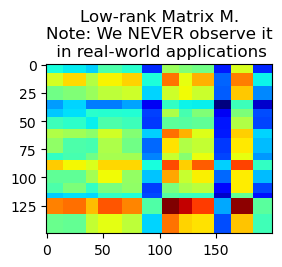

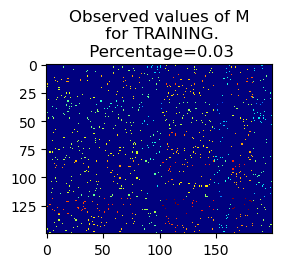

In [4]:
plt.figure(1)
plt.subplot(121).imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Low-rank Matrix M.\nNote: We NEVER observe it\n in real-world applications')
plt.show()

plt.subplot(122).imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M\n for TRAINING.\n Percentage=' + str(perc_obs_training))
plt.show()

<Figure size 640x480 with 0 Axes>

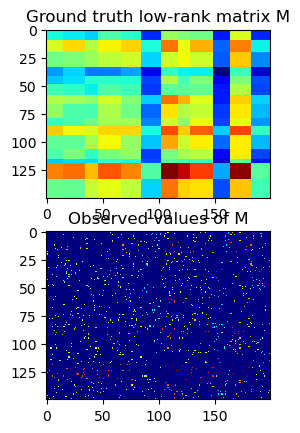

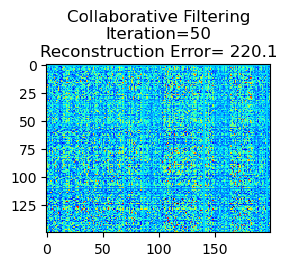

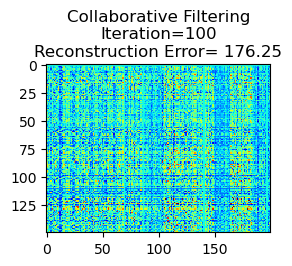

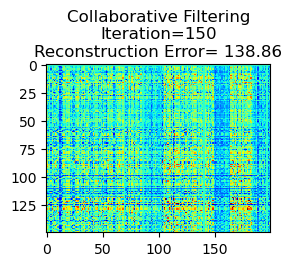

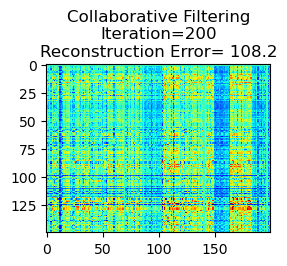

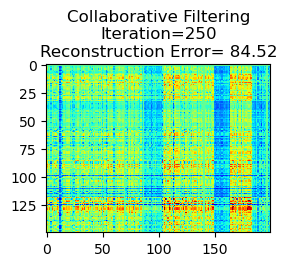

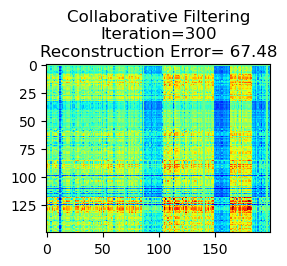

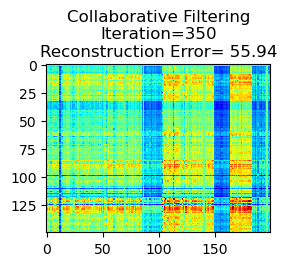

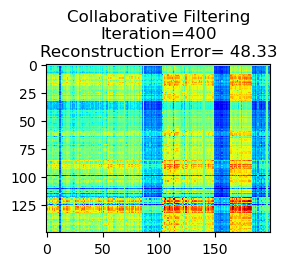

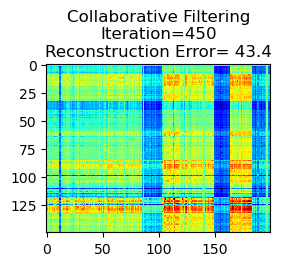

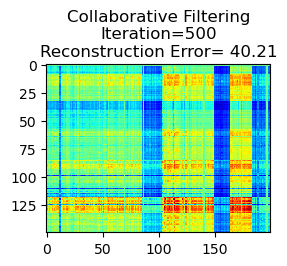

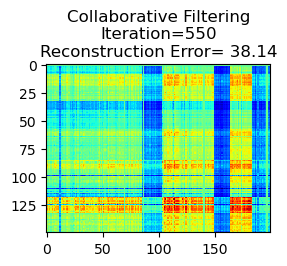

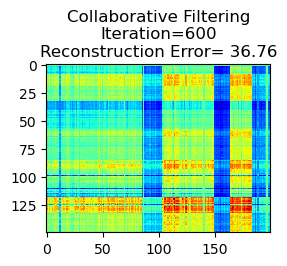

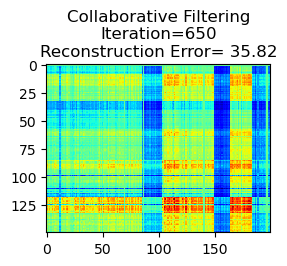

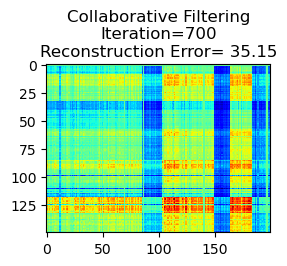

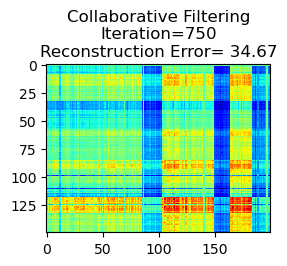

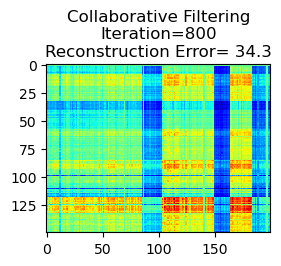

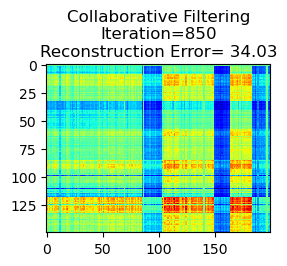

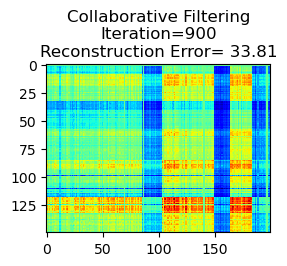

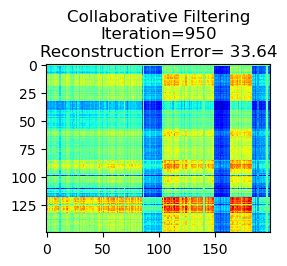

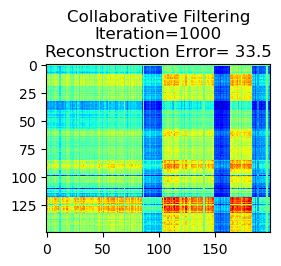

In [5]:
# Collaborative Filtering / Low-Rank Approximation by Nuclear Norm

# Indentify zero columns and zero rows in the data matrix X
idx_zero_cols = np.where(np.sum(Otraining,axis=0)<1e-9)[0]
idx_zero_rows = np.where(np.sum(Otraining,axis=1)<1e-9)[0]
nb_zero_cols = len(idx_zero_cols)
nb_zero_rows = len(idx_zero_rows)
   
# Regularization parameter
OM = O*M
normOM = np.linalg.norm(OM,2)
lambdaNuc = normOM/4.
lambdaDF = 1e3
   
# Plot
fig = plt.figure(2)
fig.canvas.draw()
plt.show(block=False)
plt.subplot(221)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Ground truth low-rank matrix M')
plt.subplot(223)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M')
plt.show()

# Initialization
X = M; Xb = X;
Y = np.zeros([n,m])
normA = 1.
sigma = 1./normA
tau = 1./normA
diffX = 1e10
min_nm = np.min([n,m])
k = 0
while (k<1000) & (diffX>1e-2):
    
    # Update iteration
    k += 1
        
    # Update dual variable y
    Y = Y + sigma* Xb
    U,S,V = np.linalg.svd(Y/sigma)
    Sdiag = shrink( S , lambdaNuc/ sigma )
    I = np.array(range(min_nm))
    Sshrink = np.zeros([n,m])
    Sshrink[I,I] = Sdiag
    Y = Y - sigma* U.dot(Sshrink.dot(V))    
    
    # Update primal variable x
    Xold = X
    X = X - tau* Y
    X = ( X + tau* lambdaDF* O* M)/ (1 + tau* lambdaDF* O)
    # Fix issue with no observations along some rows and columns
    r,c = np.where(X>0.0); median = np.median(X[r,c])
    if nb_zero_cols>0: X[:,idx_zero_cols] = median
    if nb_zero_rows>0: X[nb_zero_rows,:] = median

    # Update primal variable xb
    Xb = 2.* X - Xold
        
    # Difference between two iterations
    diffX = np.linalg.norm(X-Xold)
        
    # Reconstruction error
    err_test = np.linalg.norm(Otest*(X-Mgt))
    
    # Plot
    if not k%50:
        plt.subplot(224)
        plt.imshow(X, interpolation='nearest', cmap='jet')
        plt.title('Collaborative Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,2)))
        plt.show()
        fig.canvas.draw()
        time.sleep(0.01)
        